In [161]:

import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive,HMC,MetropolisHastings
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax

from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)


import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from numpyro.distributions.truncated import TruncatedDistribution
from numpyro.distributions import (
    Distribution,
    constraints)
from numpyro.distributions.util import is_prng_key, promote_shapes, validate_sample
from jax import lax
from SkewNormalPlus import SkewNormalPlus

ImportError: cannot import name 'MetropolisHastings' from 'numpyro.infer' (/home/bmb41/.local/lib/python3.10/site-packages/numpyro/infer/__init__.py)

In [118]:
import pickle
import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

@jit
def minmax_fit_and_scale(X):
  max= jnp.max(X,axis=0)
  min = jnp.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min

from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun

rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=20,B=3),)*5),prior=Normal())

_, log_pdf_flow, sample_flow = init_fun(flow_rng,2 )



In [156]:
file = jnp.load('flow2d2.npz',allow_pickle=True)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)

opt_params = pickle.load(open('flow2d_opt2.pkl', "rb"))
opt_state = optimizers.pack_optimizer_state(opt_params)

params = get_params(opt_state)



min_file = jnp.asarray(file['min'])
max_file = jnp.asarray(file['max'])
diff_scale = jnp.log(max_file[0]-min_file[0])

class FlowSNP(Distribution):
    arg_constraints = {"m_int": constraints.real, "sigma_int": constraints.real,"m_cut": constraints.real, "sigma_cut": constraints.real}
    support = constraints.real
    reparametrized_params = ["m_int", "sigma_int","m_cut","sigma_cut"]

    def __init__(self,m_int,sigma_int,m_cut,sigma_cut,*, validate_args=None,res=1000):


        self.min = min_file
        self.max = max_file




        self.m_int, self.sigma_int,self.m_cut,self.sigma_cut = promote_shapes(m_int,sigma_int,m_cut,sigma_cut)


        batch_shape = lax.broadcast_shapes(jnp.shape(m_int), jnp.shape(sigma_int),jnp.shape(m_int), jnp.shape(sigma_int))

        n_obj = m_int.shape[0]


        self.n_obj=n_obj



        super(FlowSNP, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )


    def sample(self,key, sample_shape=()):
        assert is_prng_key(key)



        no_samps = sample_shape[0]

        self.no_samps = no_samps

        m_col =  jnp.repeat(self.m_int.reshape(self.n_obj),no_samps).reshape(no_samps*self.n_obj,1)

        theta = jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_samps*self.n_obj).reshape(no_samps*self.n_obj,1)))



        samp=sample_flow(key, params,minmax_scale(theta,jnp.asarray(self.min[1:]),np.asarray(self.max[1:])),num_samples=self.no_samps*self.n_obj)

        samp = minmax_unscale(samp[:,0],self.min[0],self.max[0]).reshape(no_samps*self.n_obj,1) + m_col



        return samp.reshape(self.n_obj,self.no_samps).T


    @jit
    def log_prob(self, value):

        if len(value.shape)>1:
            no_samps = value.shape[0]
        else:
            no_samps=1
        no_obj = self.n_obj



        value=value.T.reshape(no_samps*no_obj,)
        value = value.reshape(no_samps*no_obj,1)


        m_col = self.m_int.reshape(no_obj,1)

        theta=jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_obj).reshape(no_obj,1)))

        theta = jnp.repeat(theta,no_samps,axis=0)

        value = value -theta[:,:1]

        X=jnp.asarray(minmax_scale(jnp.column_stack((value,theta)),min_file,max_file))


        prob = log_pdf_flow(params,X)
        prob = prob.reshape(no_obj*no_samps,)
        prob=prob.reshape(no_obj,no_samps).T - diff_scale


        return prob 




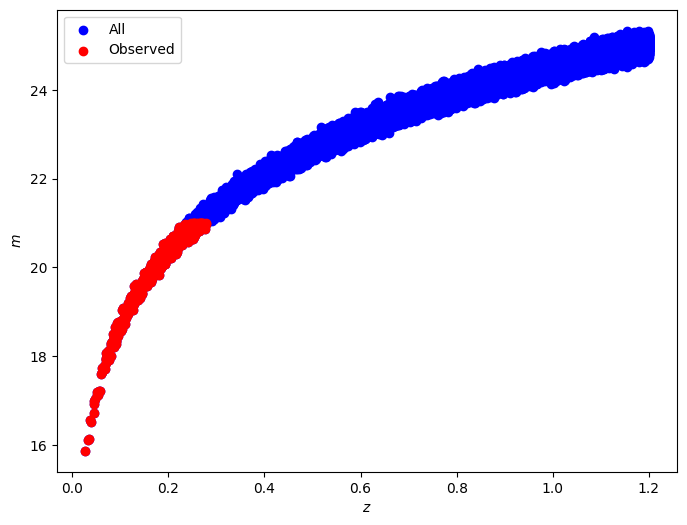

969


In [157]:


import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax

from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)


import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.coordinates import Distance

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp

from numpyro.distributions.truncated import TruncatedDistribution 

from SkewNormalPlus import SkewNormalPlus

def sample_model(z_s,mag_s=None,sel_s=None,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1,mu_cut=21,sigma_cut=0.01):

    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=mag_s)
        
        p_s=norm.cdf(-m_s,loc=-mu_cut,scale=sigma_cut)
        
        sel_s=numpyro.sample("sel_s",dist.Bernoulli(p_s),obs=sel_s)
        


def model_flat(z_s,m_s=None,sel_s=None,h=0.7324,w=-1,mu_cut=21,sigma_cut=0.01):

    
    M0=numpyro.sample('M0', dist.ImproperUniform(dist.constraints.real,(),event_shape=()))
    sigma_int = numpyro.sample("sigma_int", dist.Uniform(0,0.2))
    Om0=numpyro.sample('Om0',dist.Uniform(0,1))
    
    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_0 = M0 + mu_s
        
        m_s=numpyro.sample("m_s", FlowSNP(m_int=m_0, sigma_int=sigma_int,
                                                 m_cut=mu_cut,sigma_cut=sigma_cut), obs=m_s)
        
  

        
def naive_sample_model(z_s,mag_s=None,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1):

    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=mag_s)
        
        
        
def naive_model_flat(z_s,m_s=None,h=0.7324,w=-1):

    
    M0=numpyro.sample('M0', dist.ImproperUniform(dist.constraints.real,(),event_shape=()))
    sigma_int = numpyro.sample("sigma_int", dist.HalfCauchy(1))
    Om0=numpyro.sample('Om0',dist.Uniform(0,1))
    
    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=m_s)
        


        
u=np.random.rand(100000)

z_s=jnp.asarray((3*u)**(1/3)/(3)**(1/3)*1.2)

seed=1701

rng_key = jax.random.PRNGKey(seed)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(sample_model, num_samples=1)
prior_predictions = prior_predictive(rng_key_,z_s)

m_sim = prior_predictions["m_s"][0,:]
sel_sim = prior_predictions["sel_s"][0,:]

plt.figure(figsize=(8,6))
plt.scatter(z_s,m_sim,color='blue',label='All')
plt.scatter(z_s[sel_sim==1],m_sim[sel_sim==1],color='red',label='Observed')
plt.ylabel('$m$')
plt.xlabel('$z$')
plt.legend()
plt.show()
print(len(m_sim[sel_sim==1]))






In [144]:
#nuts_kernel = NUTS(model_flat,adapt_step_size=True)
#nuts_kernel = NUTS(model_flat,adapt_step_size=True)

rw=RandomWalkMetropolis(model=model_flat)
mcmc = MCMC(rw, num_samples=1000, num_warmup=1000,num_chains=4)
rng_key = random.PRNGKey(0)
#mcmc.run(rng_key, z_s,m_s= m_sim)




#mcmc.run(rng_key, z_s[sel_sim==1.],m_s= m_sim[sel_sim==1.],sel_s=sel_sim[sel_sim==1.])


mcmc.run(rng_key, z_s[sel_sim==1.],m_s= m_sim[sel_sim==1.])




Compiling.. :   0%|                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/2000 [00:00<?, ?it/s]


  0%|                                                  | 0/2000 [00:00<?, ?it/s]


Compiling.. :   0%|                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                 | 0/2000 [00:15<?, ?it/s]


Running chain 1:   5%|█▏                     | 100/2000 [00:43<08:51,  3.57it/s]


Running chain 0:   5%|█▏                     | 100/2000 [00:43<08:56,  3.54it/s]

Running chain 1:  10%|██▎                    | 200/2000 [01:14<08:56,  3.35it/s]

Running chain 2:  10%|██▎                    | 200/2000 [01:14<08:59,  3.34it/s]


Running chain 1:  15%|███▍                   | 300/2000 [01:45<08:38,  3.28it/s]

Running chain 2:  15%|███▍                   | 300/2000 [01:46<08:42,  3.26it/s]


Running ch


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         M0    -17.03      2.71    -19.31    -19.59    -13.92      4.57      1.93
        Om0      0.33      0.41      0.10      0.00      1.00      2.06     10.25
  sigma_int      0.14      0.04      0.13      0.10      0.20      7.15      1.84



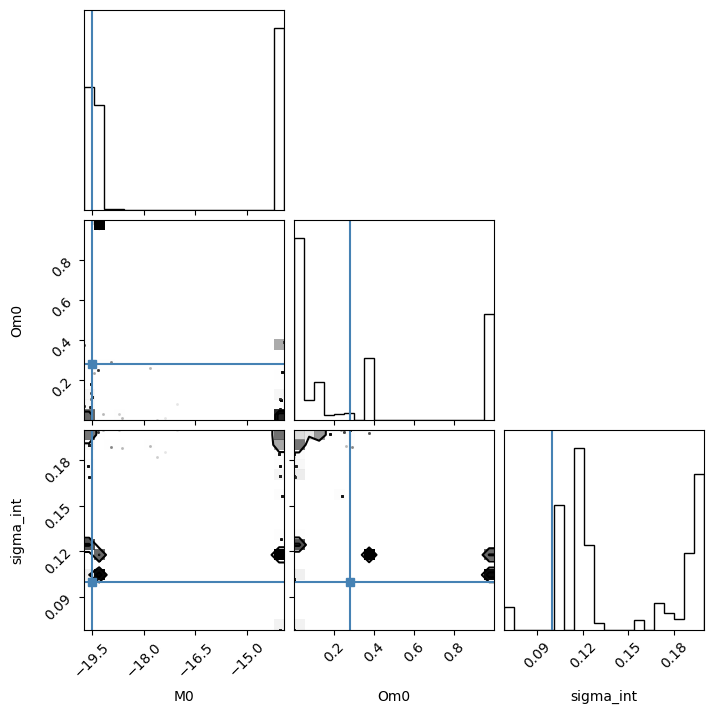

In [146]:
import corner
mcmc.print_summary()
posterior_samples = mcmc.get_samples()
a=['M0', 'Om0', 'sigma_int']


samps=np.zeros((len(a),4000))

for i in range(len(a)):
    samps[i,:]=posterior_samples[a[i]]


corner.corner(samps.T,labels=a,truths=[-19.5,0.28,0.1])
plt.show()

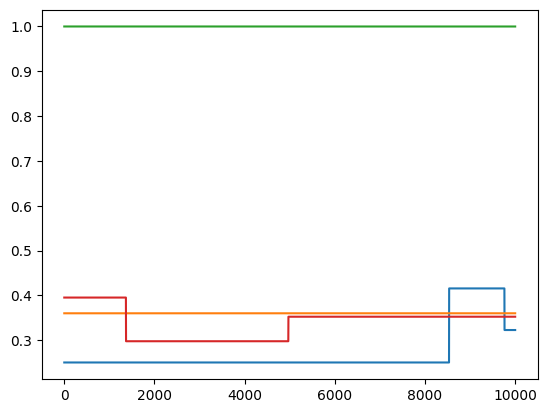

In [47]:
from matplotlib import pyplot as plt
a=posterior_samples['Om0']

plt.plot(a.reshape(4,10000).T)
plt.show()


In [17]:
print(a.reshape(1000,4))

[[0.16924423 0.16924423 0.16924423 0.16924423]
 [0.16924423 0.16924423 0.16924423 0.16924423]
 [0.16924423 0.16924423 0.16924423 0.16924423]
 ...
 [0.12733883 0.12733883 0.12733883 0.12733883]
 [0.12733883 0.12733883 0.12733883 0.12733883]
 [0.12733883 0.12733883 0.12733883 0.12733883]]


In [22]:
print(a.reshape(1000,4))

[[0.16924423 0.16924423 0.16924423 0.16924423]
 [0.16924423 0.16924423 0.16924423 0.16924423]
 [0.16924423 0.16924423 0.16924423 0.16924423]
 ...
 [0.12733883 0.12733883 0.12733883 0.12733883]
 [0.12733883 0.12733883 0.12733883 0.12733883]
 [0.12733883 0.12733883 0.12733883 0.12733883]]


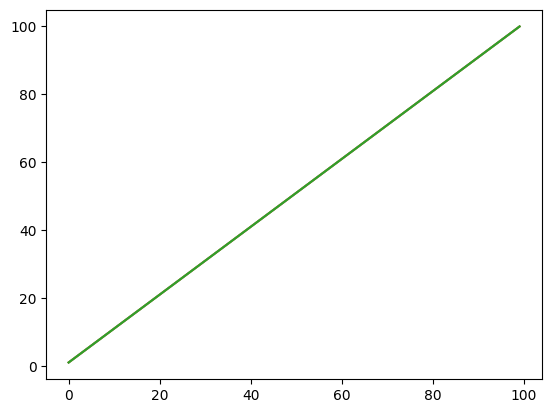

In [40]:
a=np.repeat(np.linspace(1,100,100).reshape(1,100),3,axis=0).reshape(300)


plt.plot(a.reshape(3,100).T)

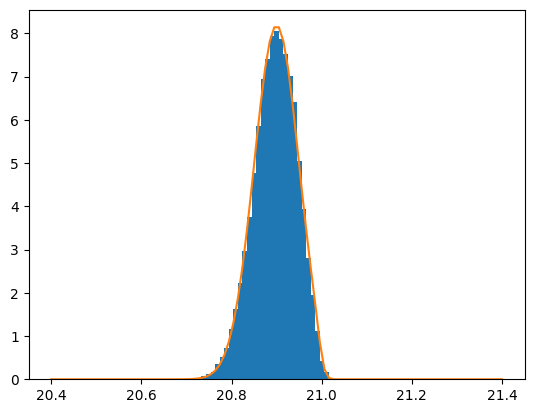

In [158]:
m=jnp.array([])
sig=0.05
cut=21
sigcut=0.01

snp=FlowSNP(m,sig,cut,sigcut)
bb  = snp.sample(rng,(100000,))
bins=np.linspace(m[0]-0.5,m[0]+0.5,100)
plt.hist(bb.reshape(100000,),density=True,bins=bins)
snp=SkewNormalPlus(m,sig,cut,sigcut)
plt.plot(bins,np.exp(snp.log_prob(bins)))
plt.show()

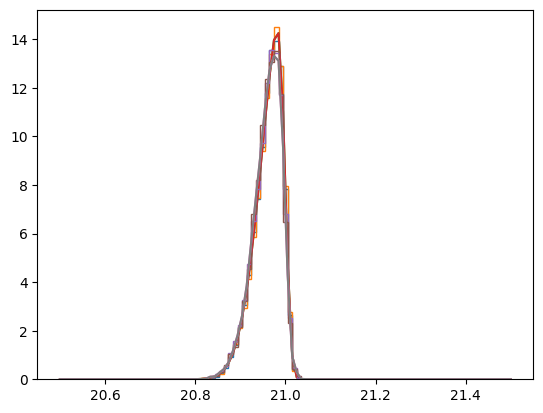

In [155]:
m=jnp.array([21,21])
sig=jnp.array([0.05])
cut=21
sigcut=0.01

snp=SkewNormalPlus(m,sig,cut,sigcut)
bb  = snp.sample(rng,(10000,2))

bins=np.linspace(m[0]-0.5,m[0]+0.5,100)
plt.hist(bb[:,0].reshape(10000,),density=True,bins=bins,histtype='step')


plt.hist(bb[:,1].reshape(10000,),density=True,bins=bins,histtype='step')

vals=snp.log_prob(np.repeat(bins.reshape(100,1),2,axis=1))
plt.plot(bins,np.exp(vals[:,0]))

plt.plot(bins,np.exp(vals[:,1]))


snp=FlowSNP(m,sig,cut,sigcut)
bb  = snp.sample(rng,(10000,2))


bins=np.linspace(m[0]-0.5,m[0]+0.5,100)
plt.hist(bb[:,0].reshape(10000,),density=True,bins=bins,histtype='step')

bins=np.linspace(m[0]-0.5,m[0]+0.5,100)
plt.hist(bb[:,1].reshape(10000,),density=True,bins=bins,histtype='step')

vals=snp.log_prob(np.repeat(bins.reshape(100,1),2,axis=1))
plt.plot(bins,np.exp(vals[:,0]))

plt.plot(bins,np.exp(vals[:,1]))


plt.show()


In [153]:
print(np.min(m_sim[sel_sim==1.]))
print(np.max( m_sim[sel_sim==1.]))

15.923740117329443
21.015431150915756
